# Setup

In [0]:
import os

from numpy.random import seed
from tensorflow import set_random_seed

In [0]:
os.environ['KAGGLE_USERNAME'] = "abhishek3450"
os.environ['KAGGLE_KEY'] = "161d7a3b3cf49266d8658ce0b6a3aa3a"

seed(100)
set_random_seed(100)

# Helper Functions

In [0]:
def search_dir(type="normal", num=6):
  #Helper function to scan contents of directory
  counter=0

  for file in os.listdir(train_dir + type.upper()+ "/"):
      if counter == num:
          break

      if file.endswith(".jpeg"):
          print(file)

      counter += 1

In [0]:
def plot_images(type="normal", num=6):
  #Helper function to plot images
  counter=0
  fig = plt.figure(figsize=(10, 8))
  

  for file in os.listdir(train_dir + type.upper()):

      if file.endswith(".jpeg"):
          if counter == num:
              break

          img = mpimg.imread(train_dir + type.upper()+"/"+file)
          plt.subplot(231+counter)
          plt.title(file.split('.')[0])
          imgplot = plt.imshow(img)

          counter += 1

In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

# Download Data

In [0]:
%time !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia #5 seconds

100% 2.29G/2.29G [00:18<00:00, 178MB/s]
100% 2.29G/2.29G [00:18<00:00, 132MB/s]
CPU times: user 183 ms, sys: 26.7 ms, total: 210 ms
Wall time: 21.7 s


In [0]:
%time !unzip chest-xray-pneumonia.zip #10 seconds

In [0]:
%time !unzip chest_xray.zip #27 seconds

In [0]:
os.remove("chest-xray-pneumonia.zip") # clean up directory a bit

# Explore Data

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [0]:
#Point to the relevant directories
train_dir = "chest_xray/train/"
val_dir   = "chest_xray/test/" #directories for training

test_dir  = "chest_xray/val/" #directory for final model scoring

In [0]:
search_dir(type="pneumonia", num=10)

In [0]:
search_dir(type="normal", num=10)

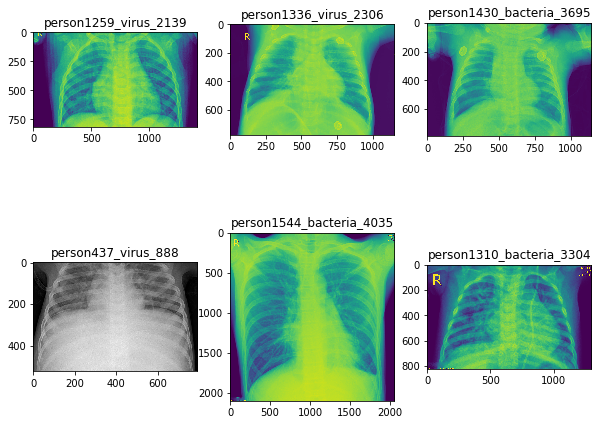

In [0]:
plot_images(type="pneumonia", num=6)

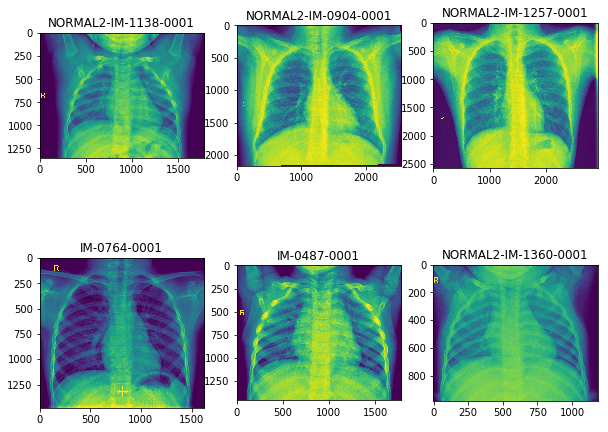

In [0]:
plot_images(type="normal", num=6)

# Modeling

### Pre-Trained Model w/o Transfer Learning

In [0]:
import numpy as np

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.python.keras.preprocessing import image

Using TensorFlow backend.


In [0]:
pre_model = InceptionV3(weights='imagenet')









96116736/96112376 [==============================] - 6s 0us/step


In [0]:
img = image.load_img( "/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg", 
                     target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = pre_model.predict(x)
for index, res in enumerate(decode_predictions(y)[0]):
    print('{}. {}: {:.3f}%'.format(index + 1, res[1], 100 * res[2]))

40960/35363 [==================================] - 0s 0us/step
1. water_bottle: 73.426%
2. isopod: 16.616%
3. scorpion: 1.624%
4. trilobite: 0.468%
5. water_jug: 0.425%


In [0]:
img = mpimg.imread("example_2.jpg")
imgplot = plt.imshow(img)

## Data Preparation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size=163


#Create training data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1) #Create image generator in the abstract

In [0]:
train_generator = train_datagen.flow_from_directory(
        train_dir, #directory that contains training data
        target_size=(150, 150), #what size image we want
        batch_size=batch_size, #how many files to read in at a time
        class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [0]:
#Create validation data generator

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="categorical")

Found 624 images belonging to 2 classes.


In [0]:
#Create validation test generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode="categorical",
        shuffle=False)

Found 16 images belonging to 2 classes.


## Train Model

In [0]:
import keras

In [0]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)


for layer in base_model.layers:
  layer.trainable = False  # Freeze the layers not to train
  
final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions) #create final model

In [0]:
final_model.compile(loss ="categorical_crossentropy", #another term for log loss
                    optimizer = "adam", 
                    metrics=["accuracy"])

In [0]:
fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch=len(train_generator),
        epochs=5,
        validation_data=val_generator, #validation data generator 
        validation_steps=len(val_generator))

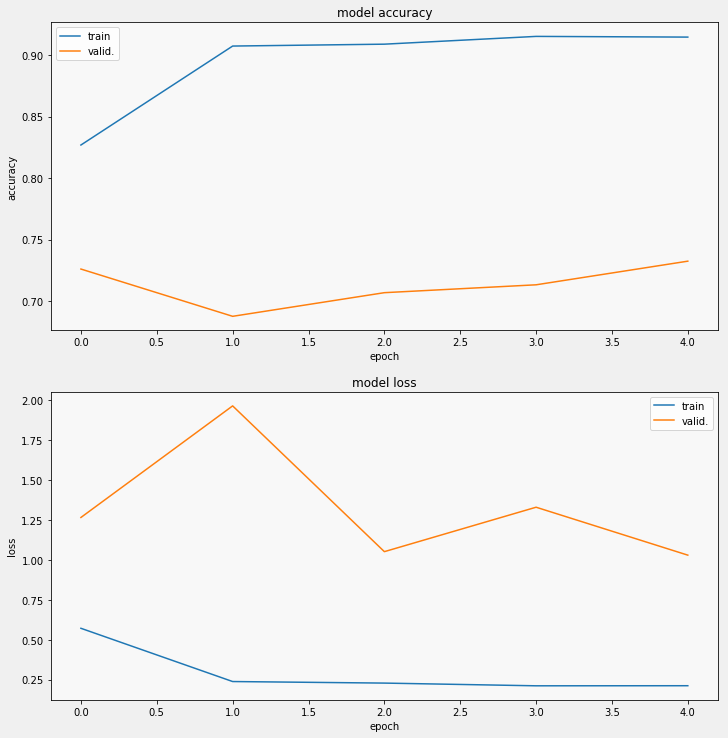

In [0]:
display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'accuracy', 211)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)

In [0]:
result  = final_model.evaluate_generator(test_generator,steps=len(test_generator))
print('Loss:', result[0])
print('Accuracy:', result[1])

Loss: 1.1195784561041373
Accuracy: 0.75


In [0]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [0]:
#Generate all predictions
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

predict

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0])

In [0]:
#Generate true labels
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

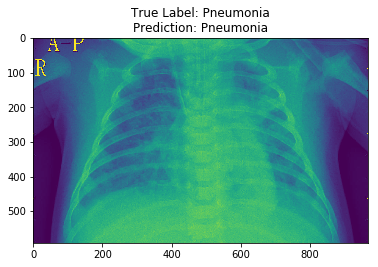

In [0]:
#@title Enter Filepath Here:
filename = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" #@param {type:"string"}

img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)